In [48]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
## To be executed once
# nltk.download('punkt')
# nltk.download('stopwords')
import re
import pickle
import time
from colorama import Fore, Back, Style

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


import urllib.request
import webbrowser

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\i22166\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\i22166\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from nltk.corpus import stopwords
#quit_words = ['quit', 'bye', 'thanks', 'exit', 'thankyou', 'thank you', 'thanku']
# sanjay
quit_words = ['quit', 'bye', 'thanks', 'exit', 'thankyou', 'thanku', 'goodbye', 'later', 'laters', "sayonara"]

greetings = ["hello","hey","hi","hello","howareyou","bot"
                 "howsitgoing","help","ineedsomehelp","ineedhelp",
                 "hithere","hellothere","hichatbot","higreatlearning",
                 "higreatlearning","anybodythere","areyouachatbot",
                 "areyouhuman","greetings","nicetomeetyou","whatsup",
                 "goodmorning","goodafternoon","goodevening",
                 "goodnight","areyoureal","youreamachine","tellmesomething",
                 "whatcanyoudo","howcanyouhelpme","ihaveaquestion",
                 "canyouhelpme","whatsyourname","greetingsbot","morning",
                 "afternoon","hellochatbot","check","test","howdy",
                 "morning","afternoon","evening","heyman","howsyourdaygoing"
                 "itsbeenawhile","howareyoudoing","sup","whatsgoingon",
                 "howseverything","howarethings","howslife","howsyourday"
                 "goodtoseeyou","nicetoseeyou","longtimenosee",
                 "pleasedtomeetyou","itsnicetomeetyou","howhaveyoubeen",
                 "howdoyoudo","yo","heymate","whazzup","gdaymate",
                 "hiya","ok","cool"
            ]

fallback_messages = ["Sorry, I don't quite understand that. Please try rephrasing your command.",
                     "Oops! I didn’t get that", 
                     "I have never heard that before. Not sure how to respond to that.",
                     "Sorry, I didn't get that. Can you say that a different way ?",
                     "Sorry but I don’t know the answer to that. Try asking me something else.",
                     "Sorry I am currently not trained for this question."]

# root to be used as random state
root = 42

In [4]:
# ## Spelling correction
# import re
# from collections import Counter

# def words(text): return re.findall(r'\w+', text.lower())

# WORDS = Counter(words(open('big_ml.txt', encoding="utf8").read()))

# def P(word, N=sum(WORDS.values())): 
#     "Probability of `word`."
#     return WORDS[word] / N

# def correction(word): 
#     "Most probable spelling correction for word."
#     return max(candidates(word), key=P)

# def candidates(word): 
#     "Generate possible spelling corrections for word."
#     return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

# def known(words): 
#     "The subset of `words` that appear in the dictionary of WORDS."
#     return set(w for w in words if w in WORDS)

# def edits1(word):
#     "All edits that are one edit away from `word`."
#     letters    = 'abcdefghijklmnopqrstuvwxyz'
#     splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
#     deletes    = [L + R[1:]               for L, R in splits if R]
#     transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
#     replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
#     inserts    = [L + c + R               for L, R in splits for c in letters]
#     return set(deletes + transposes + replaces + inserts)

# def edits2(word): 
#     "All edits that are two edits away from `word`."
#     return (e2 for e1 in edits1(word) for e2 in edits1(e1))

# def print_fallback_message(i):
#     num_of_msgs = len(fallback_messages)
#     idx = i % num_of_msgs
#     print(fallback_messages[idx])

In [5]:
# speling correction new code
import re, collections, math
import re 
from collections import Counter

def words(text): return re.findall('[a-z]+', text.lower())

WORDS = Counter(words(open('big_ml.txt', encoding="utf8").read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def valid(w):
  return all(s in WORDS for s in w.split())

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or known(justsplit1(word)) or [word])

alphabet = 'abcdefghijklmnopqrstuvwxyz '

def known(words): return set(w for w in words if valid(w))

def edits1(word):
  splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
  deletes    = [a + b[1:] for a, b in splits if b]
  transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
  replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b]
  inserts    = [a + c + b     for a, b in splits for c in alphabet]
  return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def justsplit1(word):
    "All edits that are one edit away from `word`."
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    #deletes    = [L + R[1:]               for L, R in splits if R]
    deletes    = [L               for L, R in splits if R]
    deletes1    = [R               for L, R in splits if R]
    return set(deletes + deletes1)

In [40]:
# Common functions definition

def cleanText(s1):
#    print("Inside cleanText for:", s1)  ##debug
    ps = PorterStemmer()
    text = s1.lower()
    text = re.sub(r'[0-9]*','',text)
    text = re.sub(r'^([a-z],[A-Z])*','',text)
    text = re.sub(r'\s\s+',' ',text)
    word_list = []
    for word in nltk.word_tokenize(text):
        
#        print("Original word:", word)  ## debug print
        word = correction(word)
#        print("corrected word:", word)  ##debug print
        if(word not in stopwords.words('english')):
            ps.stem(word)
            word_list.append(word)
    text = word_list
#    print('from clean text:', word_list)  ## debug
### Removed below line after adding code for spelling correction
#    text = [ps.stem(word) for word in nltk.word_tokenize(text) if word not in stopwords.words('english')]
    text = ' '.join(text)
#    print("Final sentence:", text)  ## debug print
#    print("Returning string from cleanText is:", text)  ##debug
    return text

# After prediction convert tag to response
def getResponse(tag):
    try:
        if(resp_dict[tag]):
            response = resp_dict[tag]
            return response
        else:
            print('Response not found.. Please try another query.')
    except:
        print('Response not found for:', tag)
        print('I will update my knowledge soon :)')

def process_response(response):
    if(response[0:4]=='Link'):
        url = response[5:]
#        webbrowser.open(url)
        print("Bot: url to open is {}".format(url))
    else:
        print("Bot: ", response)

def store_new_query(query):
#    print("Inside store_new_query function")  ##debug
    with open("non_corpus_queries.txt", "a") as f:
        str = inp_text + "\n"
        f.write(str)
#SANJAY
def clean_greeting(user_input: str):
#    print("Inside clean_greeting function:", user_input)  ##debug
    cleaned_word = cleanText(user_input)
    remove_spl_char = ''.join(e for e in cleaned_word if e.isalnum())
    return ''.join([i for i in remove_spl_char if not i.isdigit()]) 

def print_fallback_message(i): 
    num_of_msgs = len(fallback_messages) 
    idx = i % num_of_msgs 
    print(fallback_messages[idx])

In [7]:
df = pd.read_csv("Corpus_1.csv")
df.columns = ['query', 'response', 'tag']
df = df.dropna()


In [16]:
df.head(2)

,query,response,tag
0,What is linear regression,Link:https://en.wikipedia.org/wiki/Linear_regr...,Linear regression
1,Can you explain linear regression,Link:https://en.wikipedia.org/wiki/Linear_regr...,Linear regression


In [17]:
df['transformed_query'] = df['query'].apply(cleanText)

In [18]:
# Preparing list of queries to compare to later to store new queries
query_list = df['query'].tolist()
query_list = [i.lower() for i in query_list]

In [19]:
# encoding the target column
le = LabelEncoder()
df['tag_encoded'] = le.fit_transform(df['tag'])

In [20]:
# Converting with bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2))
X = cv.fit_transform(df['transformed_query']).toarray()

y = df['tag_encoded']

In [21]:
# Creating dataframe to visualize data
temp_name = cv.get_feature_names()
temp = pd.DataFrame(X, columns=temp_name)

In [22]:
# Create dictionary for tag to response
temp = df[['tag_encoded', 'response']]
temp = temp.groupby(['tag_encoded']).max()
resp_dict = temp.to_dict()
resp_dict = resp_dict['response']

#### Test code

In [23]:
# # Test code to check accuracy
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = root)

In [24]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier


In [25]:
#mnb = MultinomialNB()
#model = mnb.fit(X_train, y_train)

# rf = RandomForestClassifier()
# model = rf.fit(X_train,y_train)

# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# model = xgb.fit(X_train, y_train)

In [26]:
# y_pred = model.predict(X_test)

In [27]:
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test, y_pred)
# print(score)

In [51]:
test_file = pd.read_csv('test_set.csv')
#test_file = pd.read_csv('gl_test_data.csv')
test_file.columns = ['query', 'tag']
Xt1 = cv.transform(test_file['query']).toarray()

In [52]:
# le1 = le.fit(df['tag'])
# df['tag_encoded'] = le1.transform(df['tag'])

yt1 = le.transform(test_file['tag'])

In [53]:
# for testing accuracy of the test set
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model_xg = XGBClassifier(seed = 10)
model_xg = model_xg.fit(X, y)
y_pred_xg = model_xg.predict(Xt1)

print("Test File Accuracy",metrics.accuracy_score(yt1, y_pred_xg))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model_xg,f)

Test File Accuracy 0.9241379310344827


#### Test code ends here

In [30]:
# # Fitting naive bayes algorithm
# mnb = MultinomialNB()
# model = mnb.fit(X, y)

# # Mohit - we are taking accuracy on data on which we have trained model
# y_pred = model.predict(X)
# print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

# with open("bot_model.pickle",'wb') as f:
#     pickle.dump(model,f)

Validation Accuracy: 0.9592198581560284


In [31]:
# Xgboost predictor
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model_xg = XGBClassifier()
model_xg = model_xg.fit(X, y)
y_pred = model_xg.predict(X)

print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model_xg,f)

Validation Accuracy: 0.9521276595744681


In [32]:
# # Random forest classifier

# model_rf = RandomForestClassifier()
# model_rf = model_rf.fit(X, y)
# y_pred = model_rf.predict(X)
# print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

# with open("bot_model.pickle",'wb') as f:
#     pickle.dump(model_xg,f)

Validation Accuracy: 0.9929078014184397


### Model building ends here

#### Test code starts

In [33]:
# Predict using model
def process_input(s1):
#    s1 = 'What is linear regression?'
    s1 = cleanText(s1)
    l1=[]
    l1.append(s1)
    ldf = pd.DataFrame(l1, columns= ['query'])
    return ldf

In [34]:
# Test code to be removed
ss = 'search for library'
query_df = process_input(ss)
X_test     = cv.transform(query_df['query']).toarray()
prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
print(prediction)
print(prediction_proba.max())
print(prediction_proba)
print(model.classes_)
resp       = getResponse(prediction[0])
print(resp)


[22]
0.6097642757616746
[[0.0131619  0.01552399 0.03295138 0.0107674  0.03308222 0.0138275
  0.01229275 0.03599765 0.03604786 0.01003861 0.00345251 0.03668115
  0.01416683 0.03814083 0.0067548  0.00755805 0.00996192 0.00600849
  0.00345251 0.00513796 0.01000779 0.02535021 0.60976428 0.00987142]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Link: https://en.wikipedia.org/wiki/Scikit-learn


In [35]:
from matplotlib import pyplot as plt

<BarContainer object of 24 artists>

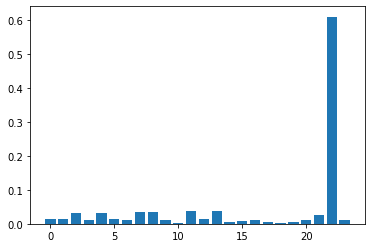

In [36]:
plt.bar(model.classes_, prediction_proba[0])

#### Testing code end here

In [37]:
# # Predict using model
# def process_input(s1):
# #    s1 = 'What is linear regression?'
#     s1 = cleanText(s1)
#     l1=[]
#     l1.append(s1)
#     ldf = pd.DataFrame(l1, columns= ['query'])
#     return ldf
    

### Start of prediction flow

#### Using pickle

In [38]:
# Trying pickle with model
pickle_in = open('./bot_model.pickle','rb')
classifier = pickle.load(pickle_in)
pickle_in.close()

### Original code to run for bot

In [42]:
# Landing message
print(Fore.RED +  "Hello. I am your machine learning assistant")
print("I can help you with your learning journey.")
print(Fore.CYAN + "You can ask me questions around algorithms and learn new stuff!!")
print(Style.RESET_ALL)
time.sleep(4)

# Get input from user
inp_text=''
i = 0
context = 'predict'

while(context != 'quit'):
    context = 'predict'
    inp_text = input('User: ')
    
### Sanjay
#    print("Cleaned text:", clean_greeting(inp_text))  ## debug
    if (clean_greeting(inp_text) in quit_words):
        context = 'quit'
#    print("After checking quit words", inp_text)  ##debug

### Sanjay
    if (clean_greeting(inp_text) in greetings):
#         print("Setting context to greeting")  ##debug
        context = 'greeting'
    
#     print("After checking greeting words:", inp_text)  ##debug
#     print("1111 context: {} and input {}".format(context, inp_text))    ##debug

    if(context != 'quit'):
        if(context != 'greeting'):
            if(inp_text.lower() not in query_list):
                store_new_query(inp_text)
            query_df   = process_input(inp_text)
            print("Input for model:", query_df)
            X_test     = cv.transform(query_df['query']).toarray()
            prediction = classifier.predict(X_test)
            max_probab = classifier.predict_proba(X_test).max()
            print("predicted value {} with probability {}".format(prediction, max_probab))   ##debug
            if (max_probab > .60):
                resp       = getResponse(prediction[0])
                process_response(resp)
            else:
                print_fallback_message(i)
                i = i + 1
        else:
            if(inp_text.lower() in ['ok','cool']):
                print("I am glad to assist you. You can ask me other questions.")
            else:
                print("Hello! how can I help you ?")
    else:
        print("Thanks. See you again")

Hello. I am your machine learning assistant
I can help you with your learning journey.
You can ask me questions around algorithms and learn new stuff!!

User: what is machine learning
Input for model:               query
0  machine learning
predicted value [10] with probability 0.47853291034698486
Sorry, I don't quite understand that. Please try rephrasing your command.
User: ok bye
Input for model:     query
0  ok bye
predicted value [21] with probability 0.4036799669265747
Oops! I didn’t get that
User: bye
Thanks. See you again


In [ ]:
# In case of bbye cleanText is returning empty string